In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
# Load data
yelp_df = pd.read_csv('/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/yelp_predictors.csv')
zillow_df = pd.read_csv('/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/house_price_changes.csv')
# Take a look at the datatypes
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17540 entries, 0 to 17539
Data columns (total 8 columns):
Unnamed: 0              17540 non-null int64
postal_code             17540 non-null object
open_business           17540 non-null float64
reviews_per_business    17540 non-null float64
avg_stars               17540 non-null float64
categories              17540 non-null float64
dis_income              17540 non-null float64
total_photo             17540 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.1+ MB


In [3]:
yelp_df.shape

(17540, 8)

In [4]:
zillow_df.shape

(30462, 9)

In [5]:
# get rid of useless rows
zillow_df_change = zillow_df.drop(columns=['Unnamed: 0', 'RegionID', 
                                    'State', 'Metro', 'avg_growth_rate_2010_2019']) #'City',

In [29]:
zillow_df_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30462 entries, 0 to 30461
Data columns (total 4 columns):
RegionName          30462 non-null int64
City                30462 non-null object
median_2015_2019    30462 non-null float64
change_2010_2019    27025 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 952.1+ KB


In [6]:
# change zip code to integer
zillow_df_change['RegionName'] = zillow_df_change['RegionName'].astype('str')

In [7]:
zillow_df_change['RegionName'] = zillow_df_change.RegionName.map(str.strip)

In [6]:
zillow_df['RegionName'].values

array([10025, 60657, 10023, ..., 22649,  6230, 43738])

In [8]:
yelp_df['postal_code'] = yelp_df.postal_code.map(str.strip)
yelp_df['postal_code'].values

array(['02645', '05440', '06032', ..., 'W8M 3T5', 'm2k 0c5', 't2g 3m5'],
      dtype=object)

In [9]:
df = zillow_df_change.merge(yelp_df, how='inner', left_on = 'RegionName', right_on='postal_code')
df.City.nunique()

371

In [15]:
df = df.drop(columns=['RegionName', 'postal_code', 'Unnamed: 0', 'median_2015_2019'])
df.shape

(659, 7)

In [16]:
# fill na with 0 instead of dropping it
#df = df.fillna(0)
df = df.dropna()
df.shape

(644, 7)

In [16]:
df.corr()

,change_2010_2019,open_business,reviews_per_business,avg_stars,categories,dis_income,total_photo
change_2010_2019,1.000000,-0.116626,0.305370,0.018361,0.409414,0.313365,0.162623
open_business,-0.116626,1.000000,-0.175816,-0.005462,-0.085405,-0.092586,-0.060419
reviews_per_business,0.305370,-0.175816,1.000000,0.034616,0.209670,0.227626,0.221826
avg_stars,0.018361,-0.005462,0.034616,1.000000,0.028038,0.041128,0.016159
categories,0.409414,-0.085405,0.209670,0.028038,1.000000,0.962456,0.628997
dis_income,0.313365,-0.092586,0.227626,0.041128,0.962456,1.000000,0.719345
total_photo,0.162623,-0.060419,0.221826,0.016159,0.628997,0.719345,1.000000


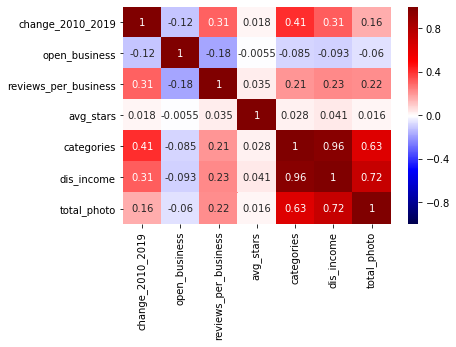

In [17]:
# corr matrix
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

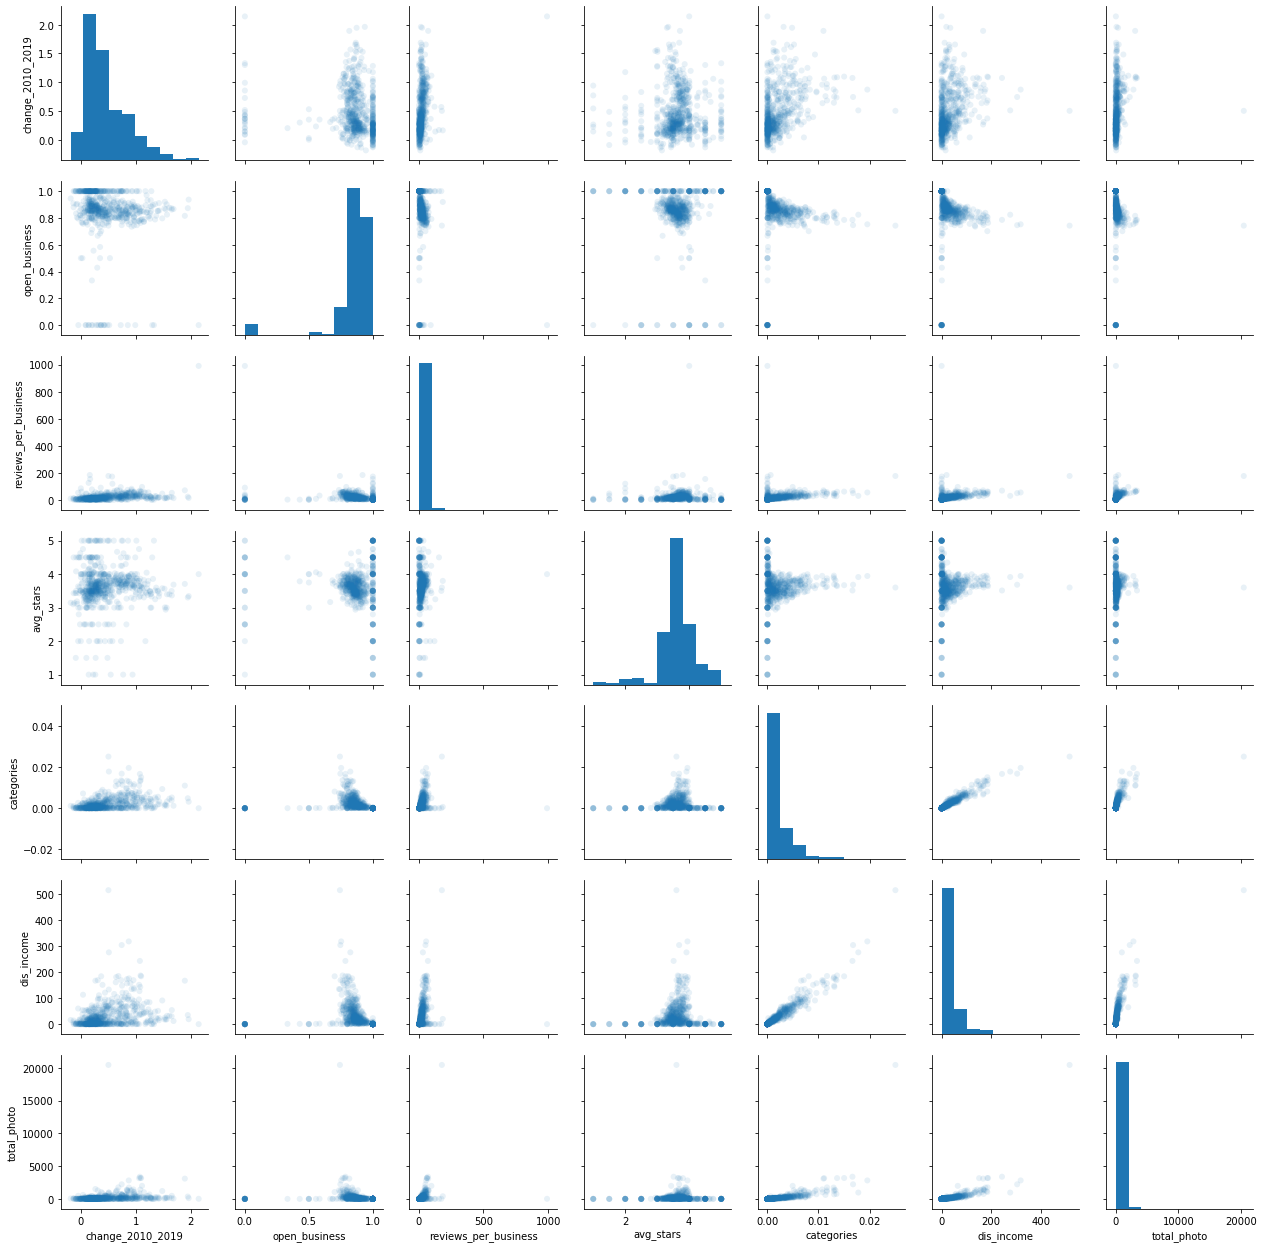

In [18]:
# Plot all of the variable-to-variable relations as scatterplots
#sns.pairplot(df, height=1.2, aspect=1.5);
sns.pairplot(df, plot_kws=dict(alpha=.1, edgecolor='none'));

In [186]:
# Ordinarly Least Squares
# Create your feature matrix (X) and target vector (y)
#sushi + New_american + bars + coffee + yoga + 
y, X = patsy.dmatrices(
    'change_2010_2019 ~ open_business + reviews_per_business + avg_stars + categories + dis_income',
    data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       change_2010_2019   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     61.14
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.66e-52
Time:                        23:40:50   Log-Likelihood:                -175.18
No. Observations:                 644   AIC:                             362.4
Df Residuals:                     638   BIC:                             389.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3652      0.098      3.711      0.000       0.172       0.558
open_business           -0.1107      0.067     -1.647      0.100      -0.243       0.021
reviews_per_business     0.0022      0.000      7.446      0.000       0.002       0.003
avg_stars                0.0107      0.021      0.502      0.616      -0.031       0.053
categories             188.7191     15.103     12.496      0.000     159.062     218.376
dis_income              -0.0098      0.001     -9.897      0.000      -0.012      -0.008
==============================================================================
Omnibus:                      127.130   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.437
Skew:                           1.178   Prob(JB):                     1.84e-49
Kurtosis:                       4.678   Cond. No.                     7.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Simple Validation Method: Train / Validation / Test
Here we will break the data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X, y = df.drop(['change_2010_2019'], axis=1), df['change_2010_2019']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [188]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [189]:
X_train.shape
X_test.shape
X_val.shape

(129, 6)

In [190]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)#.values)
X_val_scaled = scaler.transform(X_val)#.values)
X_test_scaled = scaler.transform(X_test)#.values)

lm_reg = Ridge(alpha=10)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train)#.values)
X_val_poly = poly.transform(X_val)#.values)
X_test_poly = poly.transform(X_test)#.values)

lm_poly = LinearRegression()

In [191]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression train R^2: 0.329
Linear Regression val R^2: 0.351
Ridge Regression train R^2: 0.306
Ridge Regression val R^2: 0.297
Degree 2 polynomial regression val R^2: -0.657


In [192]:
lm_reg.coef_

array([-0.00890009,  0.110752  ,  0.00840915,  0.34116048, -0.19950301,
       -0.04014123])

In [193]:
for feature, coef in zip(X.columns, lm_reg.coef_):
        print(feature, ':', f'{coef:.2f}')

open_business : -0.01
reviews_per_business : 0.11
avg_stars : 0.01
categories : 0.34
dis_income : -0.20
total_photo : -0.04


In [194]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.257


In [195]:
X_pred = lm.predict(X_test)

## Cross-Validation / Test

In [43]:
from sklearn.model_selection import KFold

X, y = df.drop('change_2010_2019', axis=1), df['change_2010_2019']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [44]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [-0.2061400221515053, 0.2335065817373245, 0.34634287752063986, 0.24480601536161473, 0.11887920808705976]
Ridge scores:  [-0.2154715720570768, 0.23563863676395225, 0.3380544115251116, 0.2436535847985586, 0.1426219954668606] 

Simple mean cv r^2: 0.147 +- 0.191
Ridge mean cv r^2: 0.149 +- 0.192


In [142]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=.01)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.257


## Vizualization

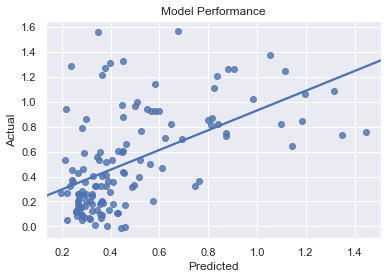

In [138]:
#plt.scatter(test_set_pred, y_test, alpha=.5)
sns.set(font_scale = 1)
ax = sns.regplot(x=X_pred, y=y_test, ci=None)
ax.set(title="Model Performance" ,xlabel='Predicted', ylabel='Actual')
plt.savefig("outputs/model_performance.svg")

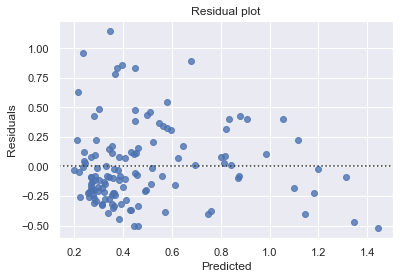

In [100]:
# create residual plot
res = y_test - X_pred
ax = sns.residplot(X_pred, res)
ax.set(title="Residual plot" ,xlabel="Predicted", ylabel="Residuals")
plt.savefig("outputs/residual_plot.svg")

In [110]:
# Plot to show variable importance coefficients
coef_df = pd.DataFrame(list(zip(X.columns, lm_reg.coef_)), columns = ["features", "coefficients"])
coef_df.head()

,features,coefficients
0,open_business,-0.008900
1,reviews_per_business,0.110752
2,avg_stars,0.008409
3,categories,0.341160
4,dis_income,-0.199503


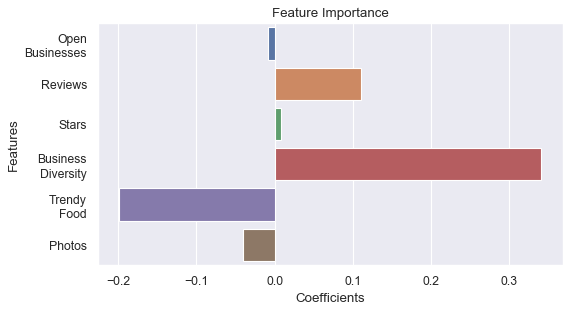

In [137]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(7.5, 4), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(data=coef_df, x = 'coefficients', y='features')
ax.set(title="Feature Importance" ,xlabel="Coefficients", ylabel="Features")
ax.set_yticklabels(['Open\nBusinesses', 'Reviews', 'Stars', 'Business\nDiversity', 'Trendy\nFood', 'Photos']) #size=20
sns.set(font_scale = .5)
plt.savefig("outputs/variable_importance_plot.svg");

## Map

In [10]:
# Load shapefile using geopandas
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [79]:
pop = pd.read_csv('/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/most_populous_cities.csv')
pop.head()

,Unnamed: 0,rank,City,State,estimate2018,population_density_sqmi,location
0,0,1,New York,New York,"8,398,748","28,317",40.6635°N 73.9387°W
1,1,2,Los Angeles,California,"3,990,456","8,484",34.0194°N 118.4108°W
2,2,3,Chicago,Illinois,"2,705,994","11,900",41.8376°N 87.6818°W
3,3,4,Houston,Texas,"2,325,502","3,613",29.7866°N 95.3909°W
4,4,5,Phoenix,Arizona,"1,660,272","3,120",33.5722°N 112.0901°W


In [80]:
pop['lat'] = pop['location'].apply(lambda x: x.split(' ')[0])
pop['long'] = pop['location'].apply(lambda x: x.split(' ')[1])

In [81]:
map_df = pop[pop['City'].isin(zillow_df_change['City'])]
map_df.head()

,Unnamed: 0,rank,City,State,estimate2018,population_density_sqmi,location,lat,long
0,0,1,New York,New York,"8,398,748","28,317",40.6635°N 73.9387°W,40.6635°N,73.9387°W
1,1,2,Los Angeles,California,"3,990,456","8,484",34.0194°N 118.4108°W,34.0194°N,118.4108°W
2,2,3,Chicago,Illinois,"2,705,994","11,900",41.8376°N 87.6818°W,41.8376°N,87.6818°W
3,3,4,Houston,Texas,"2,325,502","3,613",29.7866°N 95.3909°W,29.7866°N,95.3909°W
4,4,5,Phoenix,Arizona,"1,660,272","3,120",33.5722°N 112.0901°W,33.5722°N,112.0901°W


In [67]:
float('-' + '73.9387°W'.split('°')[0])

-73.9387

In [82]:
map_df['lat'] = map_df['lat'].apply(lambda x: float(x.split('°')[0]))
map_df['long'] = map_df['long'].apply(lambda x: float('-' + (x.split('°')[0])))
map_df.head()

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,rank,City,State,estimate2018,population_density_sqmi,location,lat,long
0,0,1,New York,New York,"8,398,748","28,317",40.6635°N 73.9387°W,40.6635,-73.9387
1,1,2,Los Angeles,California,"3,990,456","8,484",34.0194°N 118.4108°W,34.0194,-118.4108
2,2,3,Chicago,Illinois,"2,705,994","11,900",41.8376°N 87.6818°W,41.8376,-87.6818
3,3,4,Houston,Texas,"2,325,502","3,613",29.7866°N 95.3909°W,29.7866,-95.3909
4,4,5,Phoenix,Arizona,"1,660,272","3,120",33.5722°N 112.0901°W,33.5722,-112.0901


In [83]:
map_df = gpd.GeoDataFrame(map_df, geometry = gpd.points_from_xy(map_df.long, map_df.lat))
map_df = map_df[map_df['long']>-140]
map_df.head()

,Unnamed: 0,rank,City,State,estimate2018,population_density_sqmi,location,lat,long,geometry
0,0,1,New York,New York,"8,398,748","28,317",40.6635°N 73.9387°W,40.6635,-73.9387,POINT (-73.93870 40.66350)
1,1,2,Los Angeles,California,"3,990,456","8,484",34.0194°N 118.4108°W,34.0194,-118.4108,POINT (-118.41080 34.01940)
2,2,3,Chicago,Illinois,"2,705,994","11,900",41.8376°N 87.6818°W,41.8376,-87.6818,POINT (-87.68180 41.83760)
3,3,4,Houston,Texas,"2,325,502","3,613",29.7866°N 95.3909°W,29.7866,-95.3909,POINT (-95.39090 29.78660)
4,4,5,Phoenix,Arizona,"1,660,272","3,120",33.5722°N 112.0901°W,33.5722,-112.0901,POINT (-112.09010 33.57220)


In [84]:
map_df.crs = {'init' :'epsg:4326'}
#map_df.crs = {'init' :'epsg:4978'}
#EPSG:4978

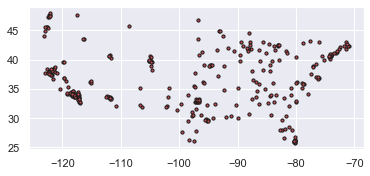

In [85]:
map_df.plot(color = "r", markersize=10, edgecolor='k')

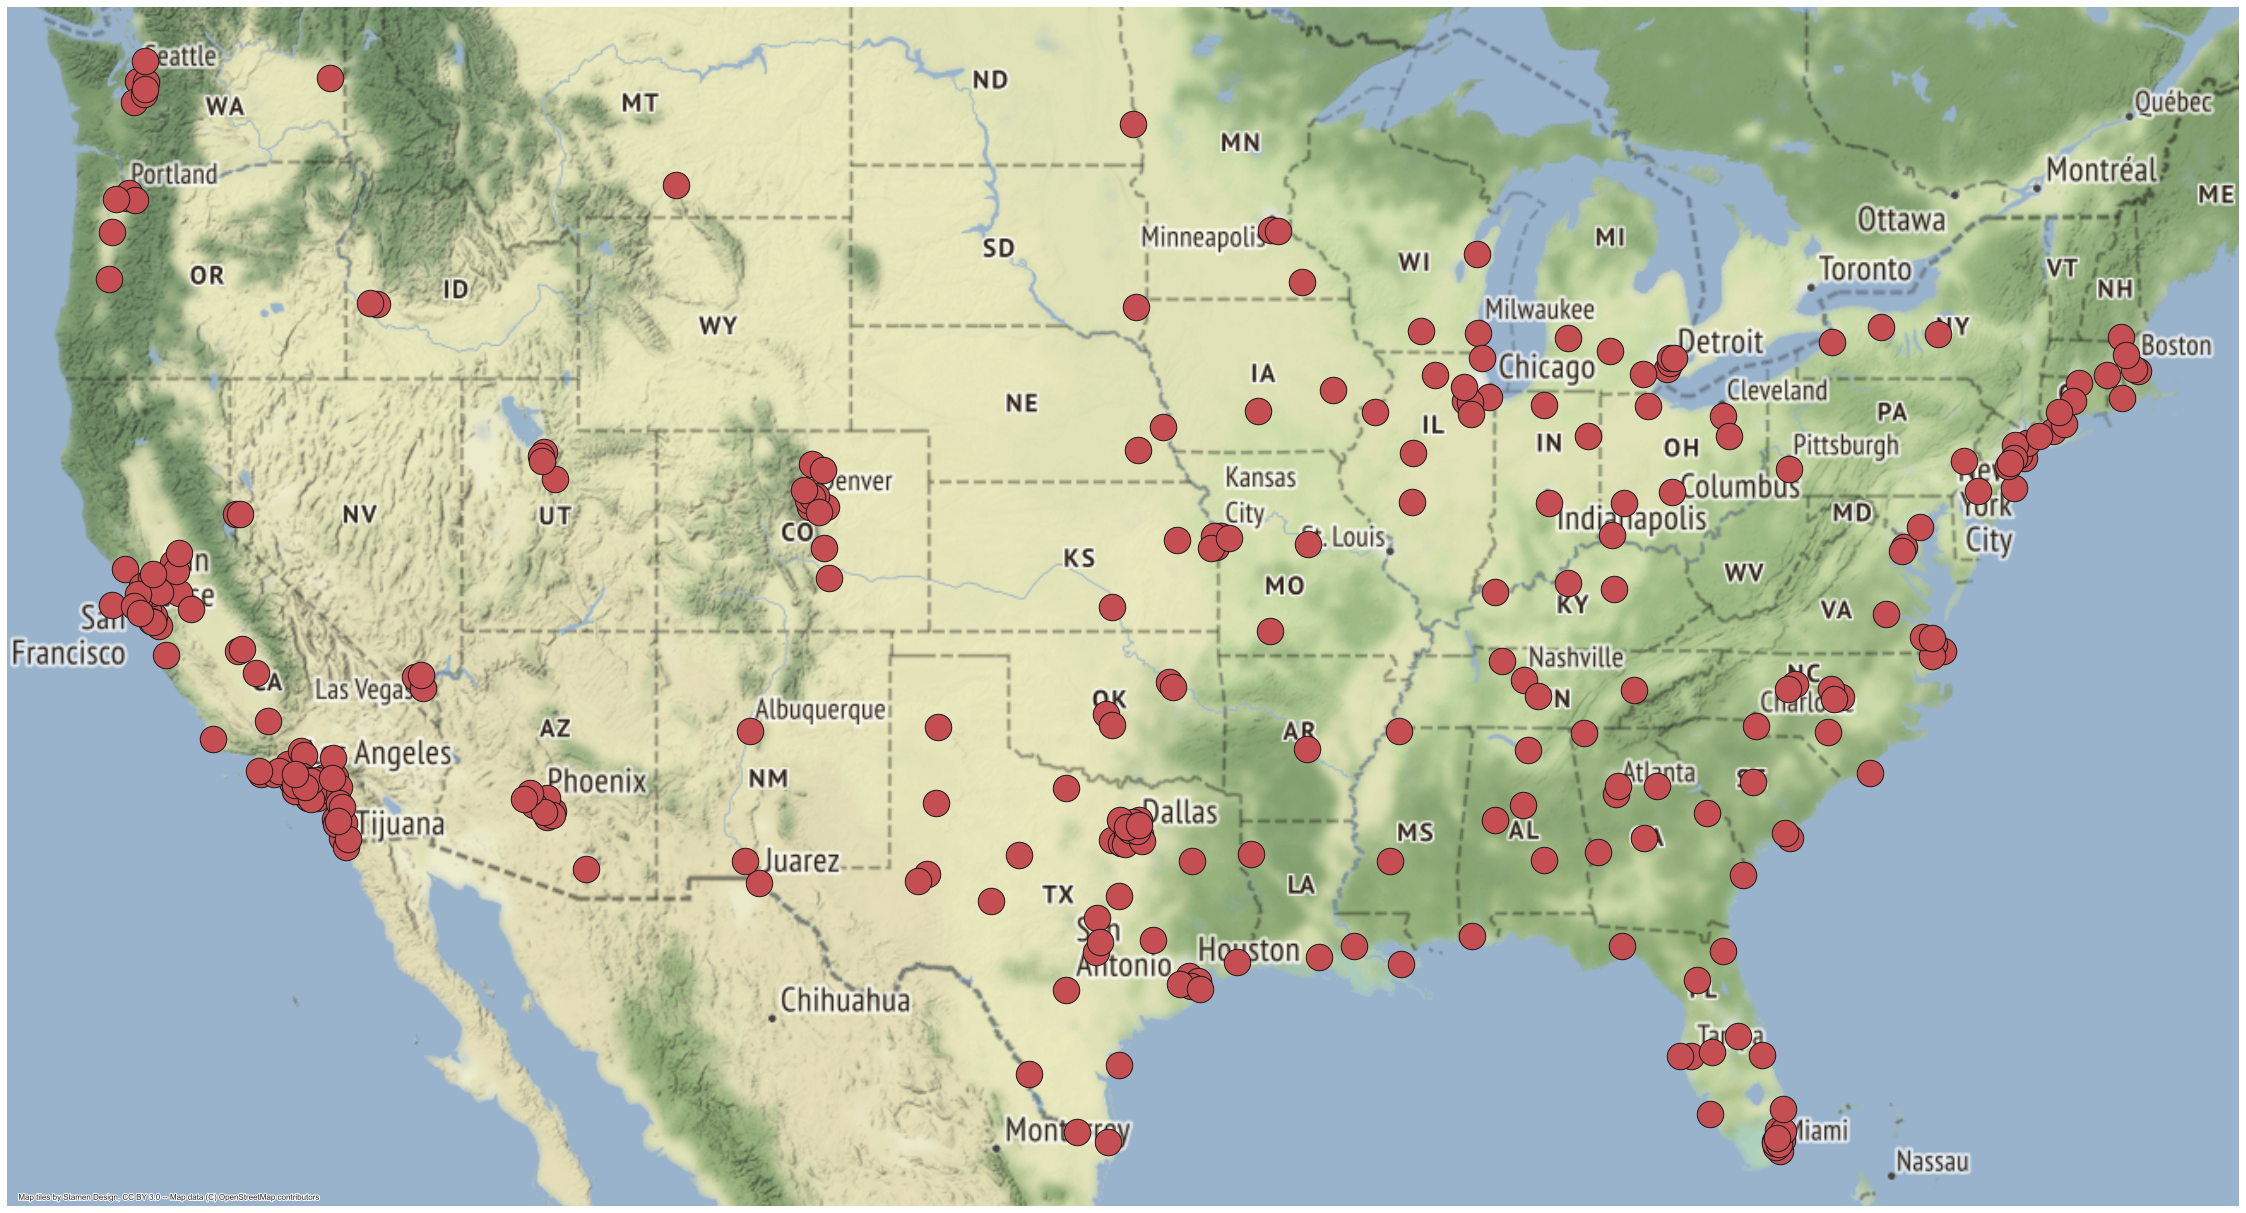

In [86]:
# Plot
#wgs = 4326
#epsg=3857
#map_df = map_df.to_crs(epsg=3857)
map_df = map_df.to_crs(epsg=3395)
ax = map_df.plot(color = "r", markersize=700, figsize=(40, 40), edgecolor='k') #alpha=0.5
ctx.add_basemap(ax)
#ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=15)
ax.set_axis_off()

# The cells below are alternative options for the target variable that I didn't end up using for my final model 

## Model median home price instead of rate of change

In [ ]:
zillow_df_median = zillow_df.drop(columns=['Unnamed: 0', 'RegionID', 'City',
                                    'State', 'Metro', 'change_2010_2019', 'avg_growth_rate_2010_2019'])

In [ ]:
# change zip code to integer
zillow_df_change['RegionName'] = zillow_df_change['RegionName'].astype('str')
df = zillow_df_change.merge(yelp_df, how='inner', left_on = 'RegionName', right_on='postal_code')
df = df.drop(columns=['RegionName', 'postal_code'])
sns.pairplot(df, height=1.2, aspect=1.5);

In [ ]:
# Ordinarly Least Squares
# Create your feature matrix (X) and target vector (y)
#sushi + New_american + bars + coffee + yoga + 
y, X = patsy.dmatrices(
    'change_2010_2019 ~ reviews_per_business + avg_stars + categories + avocado + coffee',
    data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

## Affordability

In [ ]:
# Load data
affordability_df = pd.read_csv(
    '/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/affordability_price_changes.csv')
yelp_df = pd.read_csv(
    '/Users/AuerPower/Metis/git/predict_gentrification_with_yelp/data/yelp_predictors_city.csv')

In [ ]:
# strip state name to match cities in yelp column
strip_state = lambda x: x.split(',')[0]
affordability_df['RegionName'] = affordability_df['RegionName'].apply(strip_state)

In [ ]:
strip_state = lambda x: x.split('-')[0]
affordability_df['RegionName'] = affordability_df['RegionName'].apply(strip_state)

In [ ]:
len(affordability_df['RegionName'].unique())

In [ ]:
df = affordability_df.merge(yelp_df, how='left', left_on = 'RegionName', right_on='city')
df[df.city.isnull()]

In [ ]:
#df = df.drop(columns=['Unnamed: 0', 'city'])
yelp_df[yelp_df.city=='Chicago']

In [ ]:
# drop na data just in case
df = df.dropna()
df.shape

In [ ]:
# pairplot
sns.pairplot(df, height=1.2, aspect=1.5);

In [ ]:
y, X = patsy.dmatrices(
    'change_2009_2018 ~ reviews_per_business + avg_stars + categories + avocado',
    data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()